In [1]:
using Plots, LinearAlgebra, Random
using RandomMatrices, ProgressBars
using KernelEstimator, PGFPlotsX, LaTeXStrings
using Convex, SCS, MathOptInterface
const MOI = MathOptInterface
pgfplotsx()
# const env = Gurobi.Env()

Plots.PGFPlotsXBackend()

In [2]:
using NBInclude
@nbinclude("Data_generation.ipynb")
@nbinclude("Barycenter_algorithms.ipynb")

barycenter_functional (generic function with 1 method)

# Comparing the speed of algorithms (Figure 2)

## Setting parameters (see paper for parameters used for figures)

In [41]:
n = 50
d = 50
α = .03
β = 30
κ = β / α
η₁ = 15
η₂ = 25
η₃ = 40
nIter = 20
nExp = 10;

## Solution using SDP

In [33]:
covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)

gen1(covs, sqrt_covs, α, β)
SDP(covs)

10×10 Array{Float64,2}:
 12.1908        0.648074   1.69802   …  -1.25322     0.0968149  -0.126781
  0.648082     12.0599    -1.21706      -0.42756     0.505019   -0.765788
  1.69803      -1.21706   11.5776       -0.321214   -2.2907     -2.01161
 -0.896962     -0.191355   0.428135      2.37092    -0.384697   -0.277934
  0.000534414  -1.77916   -0.451865     -0.0958492  -1.43566     1.80211
  0.0617085    -0.830219   0.255427  …  -1.05375    -0.350632   -0.99976
 -0.990793      1.18861    0.686449     -0.0894538   1.39872     1.12975
 -1.25322      -0.427567  -0.321213     12.5404     -1.94274    -0.533314
  0.0968191     0.505024  -2.29069      -1.94274    12.0236      0.902239
 -0.126775     -0.765793  -2.01161      -0.533314    0.902237   15.419

## GD and EGD

In [42]:
covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)

# Set up arrays
times = zeros(5, nExp, nIter)
objective = zeros(5, nExp, nIter)
dist = zeros(4, nExp, nIter)
optimal_objective = zeros(nExp)

for experiment in ProgressBar(1:nExp)
    
    gen1(covs, sqrt_covs, α, β)
    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    
    
    # Compute high precision solution to compare to
    sqrt_best = GD!(2*nIter, covs, sqrt_covs, zeros(2*nIter), zeros(2*nIter), 1, zeros(2*nIter), covs[:,:,1])
    optimal_objective[experiment] = barycenter_functional(sqrt_covs, sqrt_best^2)

    tmp_obj = @view objective[1, experiment, :]
    tmp_times = @view times[1, experiment, :]
    tmp_dist = @view dist[1, experiment, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₁, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[2, experiment, :]
    tmp_times = @view times[2, experiment, :]
    tmp_dist = @view dist[2, experiment, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₂, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[3, experiment, :]
    tmp_times = @view times[3, experiment, :]
    tmp_dist = @view dist[3, experiment, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₃, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[4, experiment, :]
    tmp_times = @view times[4, experiment, :]
    tmp_dist = @view dist[4, experiment, :]
    GD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, 1, tmp_dist, sqrt_best)
    
    # recenter so that timeseries starts at t=0
    times[1,experiment, :] .= times[1,experiment, :] .- times[1,experiment, 1]
    times[2,experiment, :] .= times[2,experiment, :] .- times[2,experiment, 1]
    times[3,experiment, :] .= times[3,experiment, :] .- times[3,experiment, 1]
    times[4,experiment, :] .= times[4,experiment, :] .- times[4,experiment, 1]
end

0.0%┣                                           ┫ 0/10 [00:00<00:-1, -20.0 it/s]
10.0%┣████▏                                     ┫ 1/10 [00:03<Inf:Inf, 0.0 it/s]
20.0%┣████████▉                                   ┫ 2/10 [00:07<00:54, 0.1 it/s]
30.0%┣█████████████▏                              ┫ 3/10 [00:10<00:35, 0.2 it/s]
40.0%┣█████████████████▋                          ┫ 4/10 [00:13<00:26, 0.2 it/s]
50.0%┣██████████████████████                      ┫ 5/10 [00:16<00:20, 0.2 it/s]
60.0%┣██████████████████████████▍                 ┫ 6/10 [00:20<00:16, 0.3 it/s]
70.0%┣██████████████████████████████▉             ┫ 7/10 [00:23<00:11, 0.3 it/s]
80.0%┣███████████████████████████████████▏        ┫ 8/10 [00:26<00:07, 0.3 it/s]
90.0%┣███████████████████████████████████████▋    ┫ 9/10 [00:30<00:04, 0.3 it/s]
100.0%┣██████████████████████████████████████████┫ 10/10 [00:33<00:00, 0.3 it/s]
100.0%┣██████████████████████████████████████████┫ 10/10 [00:33<00:00, 0.3 it/s]



In [43]:
# Cut off at accuracy 1e-12
log_objective = log10.(max.(dist, 1e-12))

collated = zeros(4, nIter*nExp, 2)
for algo in 1:4
    # Merge results from all experiments
    collated[algo, :, :] = [reshape(times[algo, :, :], (nIter*nExp,)) reshape(log_objective[algo, :, :], (nIter*nExp,))]
    # Sort each algorithm's data by time
    collated[algo, :, :] .= sortslices(collated[algo, :, :], dims=1, lt=(x,y)->isless(x[1],y[1]))
end


smoothed = zeros(4, nIter*nExp)
sm= 1 .* [1 1 1 1]

for algo in 1:4
    # Choose optimal smoothing parameter
    bw = sm[algo] * bwlscv(collated[algo,:,1], gaussiankernel)
    # Kernel regression on data
    smoothed[algo, :] = KernelEstimator.npr(collated[algo, :, 1], collated[algo, :, 2], kernel=gaussiankernel, reg=locallinear, h = bw)
end

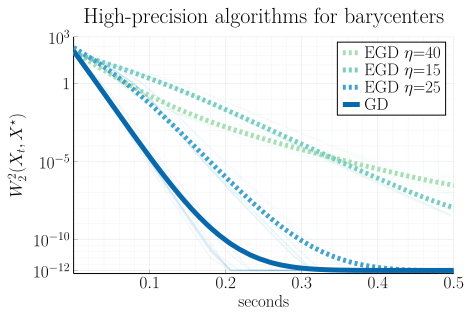

In [44]:
linestyles = [:dash :dash :dash :solid :solid]
linecolors = [4 5 3 6 2]
labels = ["EGD η=$(η₁)" "EGD η=$(η₂)" "EGD η=$(η₃)" "GD" "SDP"]
plt = plot(color_palette=palette(:GnBu_6), 
    title = "High-precision algorithms for barycenters",
    ylabel = L"W_2^2(X_t, X^\star)",
    xlabel = "seconds",
    legend=:topright, 
    minorgrid = true, 
    legendfontsize=17,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22)
for algo in [3 1 2 4]
    plot!(times[algo, :, :]', log_objective[algo, :, :]', label=nothing, linecolor=linecolors[algo], linewidth=1.5, alpha=.05)
    plot!(collated[algo, :, 1], linestyle = linestyles[algo], smoothed[algo, :], linewidth=5, linecolor=linecolors[algo], label=labels[algo])
end
xlims!(0,.5)
ylims!(-12.2, 3)
yticks!([-12, -10, -5, 0, 3], ["10^{-12}", "10^{-10}", "10^{-5}", "1", "10^3"])
xticks!([.1, .2, .3, .4, .5])
display(plt)

In [ ]:
savefig(plt, "./figures/High-precision barycenters")

# Other synthetic data (Figures 7 & 8)

## Setting parameters (see paper for parameters used for figures)

In [7]:
n = 50
d = 50
α = .03
β = 30
κ = β / α
m = Int(floor(d/4))
η₁ = 15
η₂ = 25
η₃ = 40
nIter = 20

20

In [8]:
function experiment(data_generation_method, times, objective, dist, η₁, η₂, η₃)
    covs = zeros(d,d,n)
    sqrt_covs = zeros(d,d,n)
    
    # Generate new dataset
    if data_generation_method==1
        gen1(covs, sqrt_covs, α, β)
    elseif data_generation_method==2
        gen2(covs, sqrt_covs, α, β)
    elseif data_generation_method==3
        gen3(covs, sqrt_covs, κ)
    elseif data_generation_method==4
        gen4(covs, sqrt_covs, α, β)
    elseif data_generation_method==5
        gen5(covs, sqrt_covs, α, β, m)
    elseif data_generation_method==6
        gen6(covs, sqrt_covs, α, β, m)
    elseif data_generation_method==7
        gen7(covs, sqrt_covs, α, β, κ, m)
    else
        pritnln("Error: Loss misspcified")
        return
    end
    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2


    # Compute high precision solution to compare to
    sqrt_best = GD!(2*nIter, covs, sqrt_covs, zeros(2*nIter), zeros(2*nIter), 1, zeros(2*nIter), covs[:,:,1])
    optimal_objective = barycenter_functional(sqrt_covs, sqrt_best^2)

    tmp_obj = @view objective[1, :]
    tmp_times = @view times[1, :]
    tmp_dist = @view dist[1, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₁, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[2, :]
    tmp_times = @view times[2, :]
    tmp_dist = @view dist[2, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₂, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[3, :]
    tmp_times = @view times[3, :]
    tmp_dist = @view dist[3, :]
    EGD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, η₃, thresh_a, thresh_b, tmp_dist, sqrt_best)

    tmp_obj = @view objective[4, :]
    tmp_times = @view times[4, :]
    tmp_dist = @view dist[4, :]
    GD!(nIter, covs, sqrt_covs, tmp_obj, tmp_times, 1, tmp_dist, sqrt_best)

    # recenter so that timeseries starts at t=0
    times[1, :] .= times[1, :] .- times[1, 1]
    times[2, :] .= times[2, :] .- times[2, 1]
    times[3, :] .= times[3, :] .- times[3, 1]
    times[4, :] .= times[4, :] .- times[4, 1]
end

experiment (generic function with 1 method)

In [9]:
linecolors = [4 5 3 6 2]
η₁ = 15
η₂ = 25
η₃ = 40
labels = ["EGD η=$(η₁)" "EGD η=$(η₂)" "EGD η=$(η₃)" "GD"]
plts = []
linestyles = [:dot :dot :dot :solid]


for i in 1:7
    
    times = zeros(4, nIter)
    objective = zeros(4, nIter)
    dist = zeros(4, nIter)
    experiment(i, times, objective, dist, η₁, η₂, η₃)
    log_objective = log10.(max.(dist, 1e-12))
    
    tmp = plot(color_palette=palette(:GnBu_6), 
        title = "Input $i",
        ylabel = nothing,
        xlabel = nothing,
        minorgrid = true, 
        legendfontsize=20,
        tickfontsize=17,
        labelfontsize=17, 
        titlefontsize=22)
    for algo in [4 3 1 2]
        plot!(tmp, times[algo, :], log_objective[algo, :], linestyle=linestyles[algo], linecolor=linecolors[algo], linewidth=7, label=labels[algo], legend=nothing)
        yticks!([-12, -5, 0, 3], ["10^{-12}", "10^{-5}", "1", "10^3"])
        xlims!(0,.5)
        xticks!([.2, .4], ["0.2", "0.4"])
    end
    
    push!(plts, tmp)
    if i==7
        tmp = plot(color_palette=palette(:GnBu_6), 
            title = nothing,
            ylabel = nothing,
            xlabel = nothing,
            minorgrid = true, 
            legendfontsize=20,
            tickfontsize=17,
            labelfontsize=17, 
            titlefontsize=22)
        for algo in [4 3 1 2]
            plot!(tmp, times[algo, :], log_objective[algo, :], 
                    foreground_color_axis=:white, linestyle=linestyles[algo], 
                    foreground_color_border=:white, 
                    foreground_color_grid=:white, linecolor=linecolors[algo], linewidth=7, label=labels[algo], alpha=1, grid=false, legend=:topleft)
        end
        ylims!(5,6)
        yticks!([-2,-1])
        xticks!([-10,-2])
        push!(plts, tmp)
    end
end

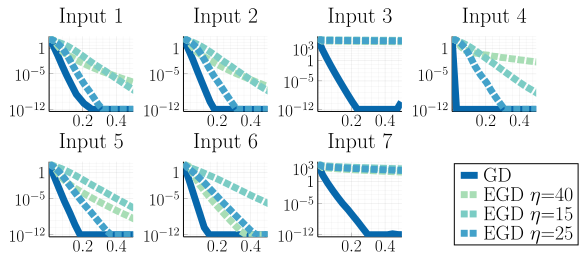

In [10]:
l = @layout [a b c d;e f g h]
plt=plot(plts[1], plts[2], plts[3], plts[4], plts[5], plts[6], plts[7], plts[8], layout=l, size = (750,350))

In [ ]:
savefig(plt, "./figures/Barycenter-synthetic")

# Dependence on dimension (Figure 1)

## Setting parameters (see paper for parameters used for figures)

In [14]:
ds = [50,100,150,200,300,400,500,1000]
# ds = [50, 100, 150, 200]
n = 50
# n = 10
α = 0.03
β = 30
κ = β / α
nIter = 30
# nIter = 100
η = [1/k for k in 1:(nIter*n)];

In [15]:
# Set up arrays
dist = zeros(nIter, length(ds), 2)
vars = zeros(length(ds))
placeholder=zeros(n*nIter)
obj = zeros(length(ds), nIter, 2)

for i in ProgressBar(1:length(ds))
    d = ds[i]
    
    covs = zeros(d,d,n)
    sqrt_covs = zeros(d,d,n)
    
#     gen1(covs, sqrt_covs, α, β)
    generate_known_bary!(covs, sqrt_covs, .1)
    
    sqrt_best = GD!(nIter, covs, sqrt_covs, zeros(nIter), zeros(nIter), 1, zeros(nIter), covs[:,:,1])
    vars[i] = barycenter_functional(sqrt_covs, sqrt_best*sqrt_best)
    
    o = @view obj[i,:,1]
    dist_tmp = @view dist[:,i,1]
    GD!(nIter, covs, sqrt_covs, o, placeholder, 1, dist_tmp, sqrt_best)
    X_SGD = zeros(d, d)
    X_SGD .= covs[:,:,1]
    for j in 1:nIter
        SGD!(covs, sqrt_covs, X_SGD, placeholder, placeholder, η[(j-1)*n+1:j*n])
        dist[j,i,2] = bures(sqrt_best, X_SGD)
        obj[i,j,2] = barycenter_functional(sqrt_covs, X_SGD)
    end
end

0.0%┣                                            ┫ 0/8 [00:00<00:00, -20.0 it/s]
12.5%┣█████▍                                     ┫ 1/8 [00:05<Inf:Inf, 0.0 it/s]
25.0%┣███████████▎                                 ┫ 2/8 [00:22<02:12, 0.0 it/s]
37.5%┣████████████████▉                            ┫ 3/8 [01:06<02:45, 0.0 it/s]
50.0%┣██████████████████████▌                      ┫ 4/8 [02:23<03:10, 0.0 it/s]
62.5%┣████████████████████████████▏                ┫ 5/8 [05:15<03:57, 0.0 it/s]
75.0%┣█████████████████████████████████▊           ┫ 6/8 [10:23<04:09, 0.0 it/s]
87.5%┣███████████████████████████████████████▍     ┫ 7/8 [18:57<03:09, 0.0 it/s]
100.0%┣█████████████████████████████████████████┫ 8/8 [01:07:09<00:00, 0.0 it/s]
100.0%┣█████████████████████████████████████████┫ 8/8 [01:07:09<00:00, 0.0 it/s]



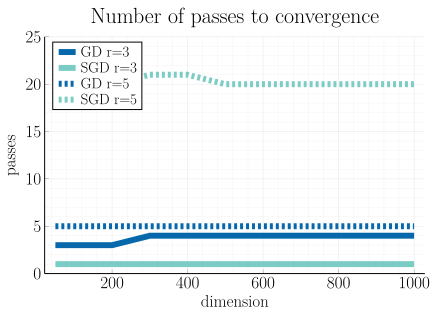

In [16]:
plt = plot(color_palette=palette(:GnBu_6), 
    title = string(L"\textrm{Number of passes to convergence}"),
    ylabel = "passes",
    xlabel = "dimension",
    legend=:topleft, 
    minorgrid = true, 
    legendfontsize=15,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22)

rs = [3 5]
for j in 1:2
    r = rs[j]
    first_index = zeros(length(ds), 2)
    v_dist = zeros(size(dist))
    for i in 1:length(ds)
        v_dist[:,i,:] .= dist[:,i,:] ./ vars[i]
    end

    arr = log10.(max.(eps(), v_dist))
    for i in 1:2
        for d in 1:length(ds)
            first_index[d, i] = nIter
            done=false
            for j in 1:nIter
                if arr[j,d,i] < -r
                    done = true
                    first_index[d, i] = min(first_index[d,i], j)
                end
            end
            if !done
                first_index[d,i] = NaN
            end
        end
    end
    
    labels = ["GD r=$(r)", "SGD r=$(r)"]
    for i in 1:2
        plot!(plt, ds, first_index[:,i], 
            label=labels[i], 
            linecolor = linecolors[i],
            linewidth = 6,
            linestyle = j==1 ? :solid : :dash)
    end
end
    ylims!(0, 25)
display(plt)

In [ ]:
savefig(plt, "./figures/Dimension-dependence")

# ESGD vs SGD (Figure 3) 

## Setting parameters (see paper for parameters used for figures)

In [11]:
n = 2000
d = 300
δ = 0.1
κ = Int(ceil((2 - δ)^2/δ^2))
η = [1/k for k in 1:(2*n)]
mults = [.1, 1, 10];

In [12]:
covs = zeros(d, d, 2*n)
sqrt_covs = zeros(d, d, 2*n)

generate_known_bary!(covs, sqrt_covs, δ)
thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2

objective_SGD = zeros(2*n, 3)
objective_ESGD = zeros(n, 3)
times_SGD = zeros(2*n, 3)
times_ESGD = zeros(n, 3)


for i in 1:3
    obj_tmp = @view objective_SGD[:,i]
    time_tmp = @view times_SGD[:,i]
    SGD!(covs, sqrt_covs, covs[:,:,1], obj_tmp, time_tmp, mults[i].*η)
    obj_tmp = @view objective_ESGD[:,i]
    time_tmp = @view times_ESGD[:,i]
    ESGD!(covs[:,:,1:n], sqrt_covs[:,:,1:n], obj_tmp, time_tmp, mults[i].*η, thresh_a, thresh_b)
end

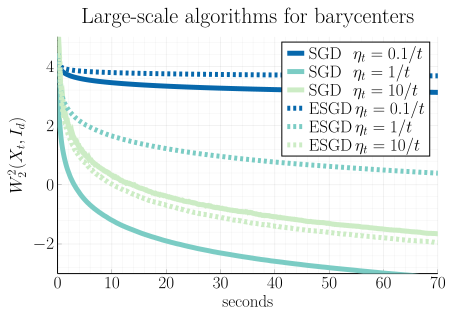

In [13]:
plot(color_palette=palette(:GnBu_6), 
    title = "Large-scale algorithms for barycenters",
    ylabel = L"W_2^2(X_t, I_d)",
    xlabel = "seconds",
    legend=:topright, 
    minorgrid = true, 
    legendfontsize=17,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22)
SGD_labels = [L"\textrm{SGD}\,\,\,\, \eta_t=0.1/t" L"\textrm{SGD}\,\,\,\, \eta_t=1/t" L"\textrm{SGD}\,\,\,\, \eta_t=10/t"]
ESGD_labels = [L"\textrm{ESGD}\, \eta_t=0.1/t" L"\textrm{ESGD}\, \eta_t=1/t" L"\textrm{ESGD}\, \eta_t=10/t"]

linecolors = [6 4 2]


plot!(times_SGD, log.(objective_SGD),  
            linecolor = linecolors, 
            linewidth = 5, 
            label=SGD_labels)
plot!(times_ESGD, log.(objective_ESGD),  
            linecolor = linecolors, 
            linewidth = 5, 
            label=ESGD_labels,
            linestyle=:dash)

ylims!(-3, 5)
xlims!(0,70)
# yticks!([-3, 0, 5], ["10^{-3}", "1", "10^5"])
# xticks!([25, 50,75])
# display(plt)

In [ ]:
savefig(plt, "./figures/Large-scale barycenters")